# Predicting Undergraduate Dropout 
Wonjoon Choi, Nathaniel Chen


## What is the problem? 
The United States experiences a severe college dropout rate every year. Only 41% of students graduate after four years without delay (ThinkImpact, 2021). Educational failure is a major social issue that impacts the whole society, causing $3.8 Billion loss annually. 

On the individual level, people with only a high school degree are approximately three times more likely to live in poverty when compared to people with a bachelor’s degree (EDI, 2021). Societally, ​​a lower education level can lead to problems with economic growth, employment, and productivity. Thus, it is important to prevent or aid students in need ahead of time so that endangered students can make their way to graduation. 


## Why is it interesting? 
Following the data analyses, we see there are certain traits that are commonly observed in dropout students. Perhaps we can use these traits to predict students at higher risk, making academic/financial aids more accessible for them. 
* 30% of College drop out in the first year
* 40% of College dropouts have parents who did not complete higher education
* only 8 to 10% of Foster kids graduate from college
* 51% of college dropouts drop out because of the lack of money. 
* 5% of students 19 years or younger drop out.
* For students between the age of 20 and 23, 51% drop out.
* 31% of African American students, and 18% of Europian  students drop out


## What has been done in the literature? 

Learning Analytics (LA) & Educational Data Mining (EDM) is a study of improving education They Gained popularity in recent years for multiple reasons. 
1. Data driven Approach were already shown to be effective in business analytics (Daradoumis et.al, 2010). So why not in employ in Education?
2. Collection of refined educational data is relatively easy 
3. Universities are always under pressure to reduce costs and increase income by reducing dropout rates and improving course quality.

These two disciplines are very similar in nature and getting combined, but in general, LA deals more with applications, and EDM focuses more on techniques and methodologies. So far, EDM methods have been focusing on exploiting classical ML methods. But why not try Neural Networks with recent advancements? 


### Data & Library Import

In [371]:
# array manipulation
import numpy as np
import pandas as pd

# plotting
import seaborn as sns
import matplotlib.pyplot as plt

# general machine learning
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# neural networks
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

We will be attempting to predict if a student will drop out of college based on his/her data profile. Knowing this is important because it will allow us to identify high risk individuals such that we can allocate more resouces to them or take time to focus on their education/habits.

In [372]:
data = pd.read_csv("dataset.csv",delimiter=';')
data.head()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Nacionality,Mother's qualification,Father's qualification,Mother's occupation,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,8,5,2,1,1,1,13,10,6,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,6,1,11,1,1,1,1,3,4,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,5,1,1,1,22,27,10,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,8,2,15,1,1,1,23,27,6,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,12,1,3,0,1,1,22,28,10,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


### Initial Data Processing

Step by step rundown of how data is processed such that it can be read into a neural network

In [373]:
# fix label name
data = data.rename(columns={'Nacionality':'Nationality'})

In [374]:
# change target to numbers
le = preprocessing.LabelEncoder()
data['Target'] = le.fit_transform(data['Target']) # {0 : Drop out , 1 : Enrolled , 2 : Graduate}

# seperate features from target
features = data.drop(columns=["Target"])
target = data.Target

Intitially we will naively treat this dataset as all the inputs given and if this is enough to give us a sense of students at risk of drop-out.

In [375]:
# split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
  features, target, test_size=0.33)

# convert sets into tensor-readable arrays
X_train_np = X_train.values
X_test_np = X_test.values
y_train_np = y_train.values
y_test_np = y_test.values

In [376]:
class Data(Dataset):
  def __init__(self, X_train, y_train):
    self.X = torch.from_numpy(X_train.astype(np.float32)) # needs to be float
    self.y = torch.from_numpy(y_train).type(torch.LongTensor) # needs to be Long
    self.len = self.X.shape[0]
  
  def __getitem__(self, index):
    return self.X[index], self.y[index]
  def __len__(self):
    return self.len

In [377]:
batch_size = 50
traindata = Data(X_train_np,y_train_np)
trainloader = DataLoader(traindata, batch_size=batch_size, shuffle=True, num_workers=0) # split data into smaller groups

In [378]:
# Network class parameters
input_dim = len(features.columns)
output_dim = 3
hidden = (input_dim + output_dim) // 2 # should be between input and output dimensions

A perceptron will be initially used. Leaky ReLU will be used as the activation function since it's generally reliable and won't die.

In [379]:
class Network(nn.Module):
  def __init__(self):
    super().__init__()
    self.leakyrelu = nn.LeakyReLU(0.001)
    self.linear1 = nn.Linear(input_dim,hidden)
    self.linear2 = nn.Linear(hidden,output_dim)

  def forward(self, x):
    x = self.leakyrelu(self.linear1(x))
    x = self.linear2(x)
    return x

In [380]:
clf = Network()
print(clf.parameters)

<bound method Module.parameters of Network(
  (leakyrelu): LeakyReLU(negative_slope=0.001)
  (linear1): Linear(in_features=34, out_features=18, bias=True)
  (linear2): Linear(in_features=18, out_features=3, bias=True)
)>


In [381]:
criterion = nn.CrossEntropyLoss() # most common loss criterion
optimizer = torch.optim.SGD(clf.parameters(), lr=0.001, weight_decay=1e-5)

In [382]:
# confusion matrix for evaluation - will be used later on
def plot_confusion_matrix(matrix,title=""): 
    #put the heatmap into the figure 
    sns.heatmap(data=matrix, annot=True, cmap="crest")
    status=["Drop-out","Enrolled","Graduate"]
    axis_ticks=np.arange(len(status))+0.4
    
    #sets x axis ticks to species names
    plt.xticks(axis_ticks,status) 
    
    #sets y axis ticks to species names 
    plt.yticks(axis_ticks,status) 
    plt.title(title)
    plt.ylabel("Actual Label")
    plt.xlabel("Predicted Label")

### Initial Training

In [383]:
epochs = 900 # determined by hand to be around the best performance with given hyperparameters
loss_arr = [i for i in range(epochs)]
for epoch in range(epochs):
  running_loss = 0.0
  for i, data in enumerate(trainloader, 0):
    inputs, labels = data
    optimizer.zero_grad() # set optimizer to zero grad to remove previous epoch gradients
    outputs = clf(inputs) # forward propagation
    loss = criterion(outputs, labels)
    loss.backward() # backward propagation
    optimizer.step() # optimize
    running_loss += loss.item()
  # display statistics
  if epoch % 100 == 0:
    print(f'epoch: {epoch}, loss: {running_loss}')
  loss_arr[epoch] = running_loss

epoch: 0, loss: 67.30755257606506
epoch: 100, loss: 36.4720765799284
epoch: 200, loss: 35.0386518985033
epoch: 300, loss: 34.650494158267975
epoch: 400, loss: 34.1468839943409
epoch: 500, loss: 33.54779267311096
epoch: 600, loss: 32.9418021440506
epoch: 700, loss: 32.81580311059952
epoch: 800, loss: 32.39692196249962


Text(0.5, 1.0, 'SGD, batch size = 50')

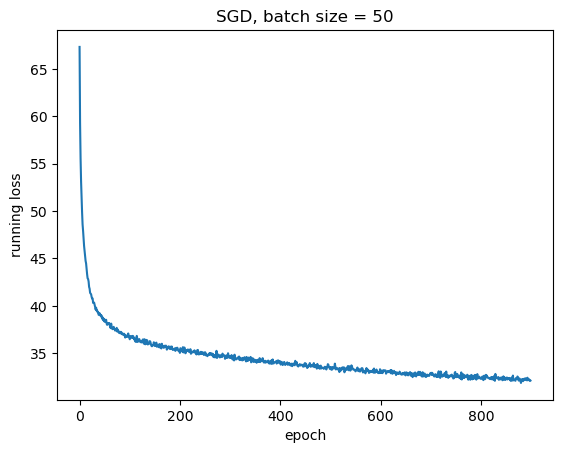

In [384]:
plt.plot(loss_arr)
plt.xlabel("epoch")
plt.ylabel("running loss")
plt.title(f"SGD, batch size = {batch_size}")

### Testing

In [385]:
testdata = Data(X_test_np, y_test_np)
outputs = clf(testdata.X)
__, predicted = torch.max(outputs, 1)

In [386]:
print(accuracy_score(predicted,testdata.y))

0.7575342465753425


The random accuracy will be around 1/3 since there are 1/3 options uniformly distributed. Experimental validation here.

In [387]:
rand_predictions = np.random.randint(0,3,size=testdata.len)
print(accuracy_score(rand_predictions,testdata.y))

0.35753424657534244


### Other Neural Network Parameters

While the torch neural network shows how the multi-layer perceptron is handled, this can be done more easily with scikitlearn's MLPClassifier. Since all this is done on a set of smaller tabular data, large processing is not needed so a cpu can handle computations pretty fast. The question we're asking here is if certain hyperparameters can reliably improve the performance of this network. In other words, how good of a prediction can we get simply by tuning this neural network?

In [388]:
len(X_train.columns)

34

In [389]:
# CNN
nn = MLPClassifier(hidden_layer_sizes = (24,16),
                   activation = "relu", # Activation function for the hidden layer.
                   alpha = 0.001, # Strength of the L2 regularization term.
                   batch_size = 'auto',# Size of minibatches for stochastic optimizers.
                   learning_rate_init = 0.01, 
                   epsilon =1e-6,
                   max_iter = 1000,
                   shuffle = True,# shuffle samples in each iteration
                   early_stopping = True,
                   random_state=69,
                   verbose = False) # Allows to print progress messages to stdout.

nn.fit(X_train.values, y_train.values)

MLPClassifier(alpha=0.001, early_stopping=True, epsilon=1e-06,
              hidden_layer_sizes=(24, 16), learning_rate_init=0.01,
              max_iter=1000, random_state=69)

In [390]:
print(f"training score: {nn.score(X_train.values,y_train.values)}")
print(f"testing score: {nn.score(X_test.values,y_test.values)}")

training score: 0.7881241565452092
testing score: 0.7513698630136987


c:\Users\twoga\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


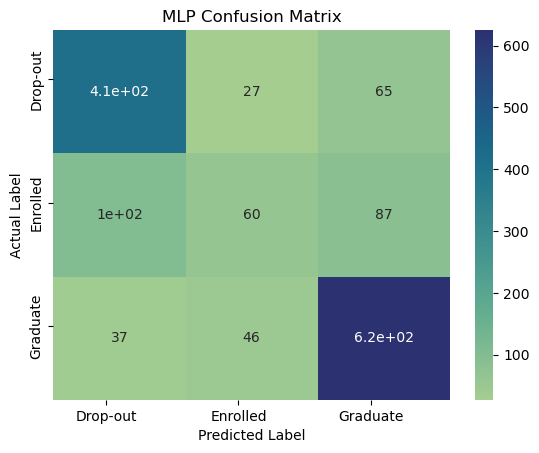

In [391]:
### IN PROGRESS - NEED TO WRITE MORE ABOUT THIS
y_train_pred = nn.predict(X_test)
cnn_matrix = confusion_matrix(y_test,y_train_pred)
plot_confusion_matrix(cnn_matrix, title="MLP Confusion Matrix")

After much tuning, the MLP classifier consistently stays around 0.75 for testing score so parameters will not be varied much anymore. A grid search will not be shown since some parameters are dependant on each other.

Some interesting parameters to note:
1. Hidden Layer Sizes: A lot of variations have been performed but without much effect. As overfitting is expected to happen when there are more nodes in hidden layers than the input layer, the hidden layer sizes are kept in between the input and output layer. Depth has also been experimented on widely, showing little effect on the accuracy of the network. Therefore it the parameter will be kept at 2 layers with 24 then 16 nodes for the sake of it.
1. Activation: ReLU and identity seem to perform the best, despite being complete opposites in terms of complexity. The other tanh and sigmoid functions drop off in performance, which is expected compared to relu but not identity.
1. Early Stopping: Without early stopping, the testing score can decrease by 2-3% either due to under or overfitting. Setting a high maximum iteration and early stopping parameter is good for getting the optimal parameter as the function looks for when the gradient stops dropping.


### Other Machine Learning Approaches

Although these neural network results are good, they're still not very reliable predictors. The question can be futher generalized - is the reliablity of this a result of the type of model we're using? We can simply compare this neural network to other machine learning models to see how they stack up against each other.

#### Random Forest approach

In [392]:
# Finds best depth for Random Forest Classifier
def find_best_depth(model): 
    # Max Depth iteration
    N = 30
    # set initial list length of N
    scores = np.zeros(N)
    best_score = -np.inf
    for d in range(1,N+1):
                # set model with random state
        ref = model(max_depth=d,random_state=1111)
        # calculate score
        scores[d-1] = cross_val_score(ref,X_train,y_train,cv=5).mean() 
        if scores[d-1] >best_score:
                # update best_score and best_depth
                best_score=scores[d-1]
                best_depth = d
        # plot scatter plot
    fig, ax = plt.subplots(1) 
    ax.scatter(np.arange(1,N+1),scores)
    ax.set(title="Best Depth: " + str(best_depth)) 
    return best_depth

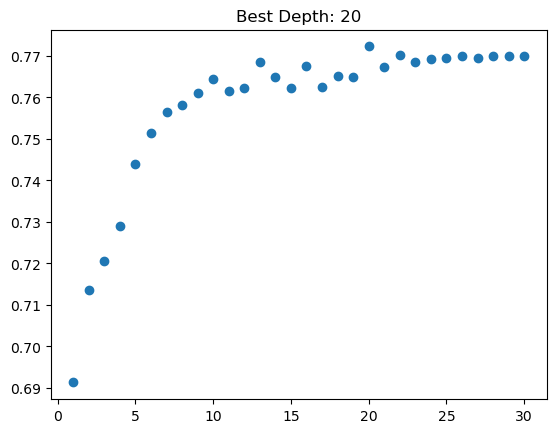

In [393]:
best_depth = find_best_depth(RandomForestClassifier)

In [394]:
RF = RandomForestClassifier(max_depth=best_depth,random_state=1111)
RF.fit(X_train.values,y_train.values)

y_train_pred = RF.predict(X_test.values)
RF_matrix = confusion_matrix(y_test.values,y_train_pred)

In [396]:
RF.score(X_test.values,y_test.values)

0.7767123287671233

c:\Users\twoga\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


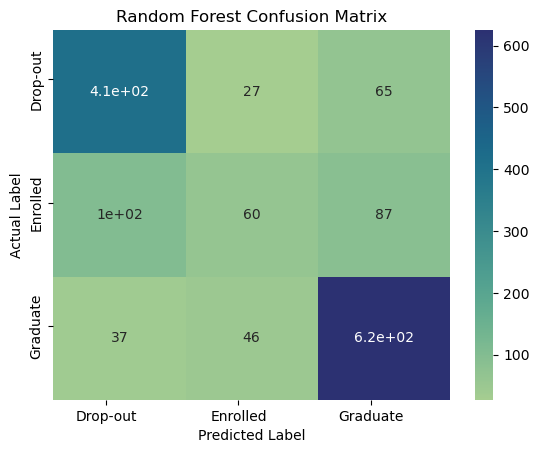

In [397]:
### IN PROGRESS - NEED TO WRITE MORE ABOUT THIS
y_train_pred = nn.predict(X_test)
forest_matrix = confusion_matrix(y_test,y_train_pred)
plot_confusion_matrix(cnn_matrix, title="Random Forest Confusion Matrix")

### Support Vector Machine approach

In [398]:
clf = SVC(kernel='linear')
clf.fit(X_train.values,y_train.values)
clf.score(X_test.values,y_test.values)

0.7760273972602739

c:\Users\twoga\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


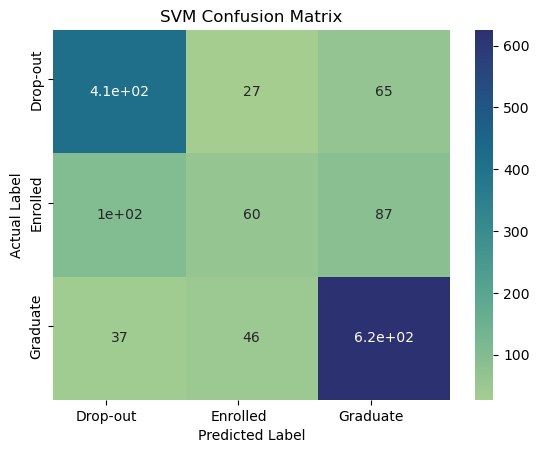

In [399]:
### IN PROGRESS - NEED TO WRITE MORE ABOUT THIS
y_train_pred = nn.predict(X_test)
svm_matrix = confusion_matrix(y_test,y_train_pred)
plot_confusion_matrix(cnn_matrix, title="SVM Confusion Matrix")

It seems like all these results give around the same ~77% accuracy range, though the non-neural network methods perform slightly bettter than the neural network. This could be due to the auto parameter tuning within these models which simply returns the best hyperparameter results. But since both the non-neural network models perform around the same as the neural network model, the question of opimization can be pushed further back - is there something intrinsic about the data that plays a role in our accuracy?

### Data Processing Revisited - Feature Selection and Pre-Processing
Now that we're back at the beginning, there are some questions we can address:
1. How are we treating the categorical data?
1. Are there variables that play higher roles than other (feature selection)?
1. How can we standardize the data?

Perhaps some of these play a role, perhaps none do. So we can try to play around with to see what happens. Since this project is in terms of neural networks, MLPClassifier will be used to evaluate all these parameter changes. However, the input size changes across different test cases. Since hidden layer sizes depend on the input parameters, SVC will also be employed as a standard benchmark for performance changes due to data processing.

#### Categorical Feature Processing - One Hot Encoding

It's strange to treat categorical values like 1,2,3,4 as actual numbers. When the math is done on them, they would bias towards a certain set of values away from the edges, which isn't how categories are meant to be treated. So the idea is to vectorize them such that each variable becomes a vector of binary states. One Hot Encoding does this.

In [400]:
features

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Nationality,Mother's qualification,Father's qualification,Mother's occupation,...,Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP
0,1,8,5,2,1,1,1,13,10,6,...,0,0,0,0,0,0.000000,0,10.8,1.4,1.74
1,1,6,1,11,1,1,1,1,3,4,...,0,0,6,6,6,13.666667,0,13.9,-0.3,0.79
2,1,1,5,5,1,1,1,22,27,10,...,0,0,6,0,0,0.000000,0,10.8,1.4,1.74
3,1,8,2,15,1,1,1,23,27,6,...,0,0,6,10,5,12.400000,0,9.4,-0.8,-3.12
4,2,12,1,3,0,1,1,22,28,10,...,0,0,6,6,6,13.000000,0,13.9,-0.3,0.79
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4419,1,1,6,15,1,1,1,1,1,6,...,0,0,6,8,5,12.666667,0,15.5,2.8,-4.06
4420,1,1,2,15,1,1,19,1,1,10,...,0,0,6,6,2,11.000000,0,11.1,0.6,2.02
4421,1,1,1,12,1,1,1,22,27,10,...,0,0,8,9,1,13.500000,0,13.9,-0.3,0.79
4422,1,1,1,9,1,1,1,22,27,8,...,0,0,5,6,5,12.000000,0,9.4,-0.8,-3.12


In [401]:
categorical_labels = ['Marital status', 'Application mode', 'Application order', 'Course',
       'Daytime/evening attendance', 'Nationality',
       'Mother\'s occupation', 'Father\'s occupation', 'Displaced',
       'Educational special needs', 'Debtor', 'Tuition fees up to date',
       'Gender', 'Scholarship holder']

one_hot = pd.get_dummies(features,columns=categorical_labels)
one_hot.columns
X_train, X_test, y_train, y_test = train_test_split(
  one_hot, target, test_size=0.33)

In [402]:
nn = MLPClassifier(hidden_layer_sizes = (164,128,96),
                   activation = "relu", # Activation function for the hidden layer.
                   alpha = 0.001, # Strength of the L2 regularization term.
                   batch_size = 'auto',# Size of minibatches for stochastic optimizers.
                   learning_rate_init = 0.01, 
                   epsilon =1e-6,
                   max_iter = 1000,
                   shuffle = True,# shuffle samples in each iteration
                   early_stopping = True,
                   random_state=69,
                   verbose = False) # Allows to print progress messages to stdout.

nn.fit(X_train.values, y_train.values)
print(f"training score: {nn.score(X_train.values,y_train.values)}")
print(f"testing score: {nn.score(X_test.values,y_test.values)}")

training score: 0.7982456140350878
testing score: 0.7746575342465754


In [403]:
clf = SVC(kernel='linear')
clf.fit(X_train.values,y_train.values)
clf.score(X_test.values,y_test.values)

0.7773972602739726

#### Feature Selection

This might not be a issue in the moment, but splitting to so many columns may introduce unrelated noise, so removing columns may help. This is where feature selection comes in: either the mutual information of each column is correlated to test the impact of variables on a target or a decision tree is used to test the impact of vaeriables on a target. Just to clarify, feature selection is not exclusively PCA. PCA only looks at features - the methods used here also look at the target.

In [454]:
# feature selection
def select_features(features, target, num_features = 5, run_type = 0):
    plt.rcParams.update({'font.size': 5})
    if run_type == 0:
        importance = mutual_info_classif(features,target)
        ft_imp = pd.Series(importance, index=features.columns)
        title = "Mutual Info Importance"
    elif run_type == 1:
        model = ExtraTreesClassifier()
        model.fit(features,target)
        ft_imp = pd.Series(model.feature_importances_, index=features.columns)
        title = "Extra Trees Classifier Importance"

    
    largest = ft_imp.nlargest(num_features).index
    ft_imp.nlargest(num_features).plot(kind="barh")
    plt.title(title)
    plt.tight_layout()
    plt.show()

    return largest

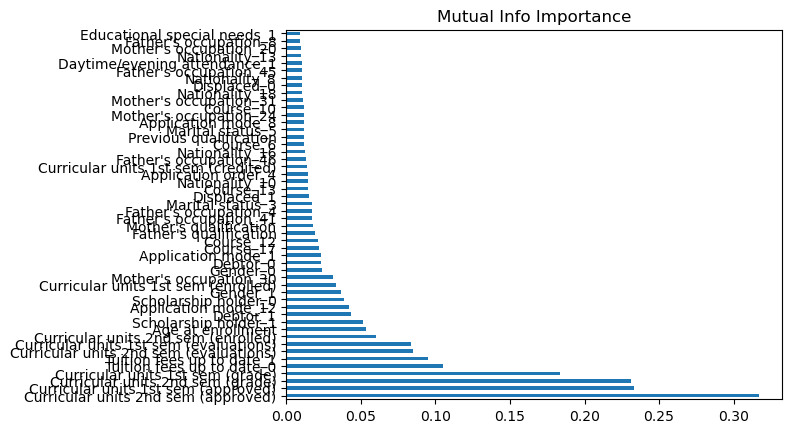

In [455]:
largest = select_features(one_hot, target, 50, 0)

In [406]:
categorical_labels_filter = list(set(categorical_labels).intersection(largest))
X_train, X_test, y_train, y_test = train_test_split(
  one_hot[largest], target, test_size=0.33)

In [407]:
nn = MLPClassifier(hidden_layer_sizes = (50,40),
                   activation = "relu", # Activation function for the hidden layer.
                   alpha = 0.001, # Strength of the L2 regularization term.
                   batch_size = 'auto',# Size of minibatches for stochastic optimizers.
                   learning_rate_init = 0.01, 
                   epsilon =1e-6,
                   max_iter = 1000,
                   shuffle = True,# shuffle samples in each iteration
                   early_stopping = True,
                   random_state=69,
                   verbose = False) # Allows to print progress messages to stdout.

nn.fit(X_train.values, y_train.values)
print(f"training score: {nn.score(X_train.values,y_train.values)}")
print(f"testing score: {nn.score(X_test.values,y_test.values)}")

training score: 0.8063427800269906
testing score: 0.7691780821917809


In [408]:
clf = SVC(kernel='linear')
clf.fit(X_train.values,y_train.values)
clf.score(X_test.values,y_test.values)

0.7705479452054794

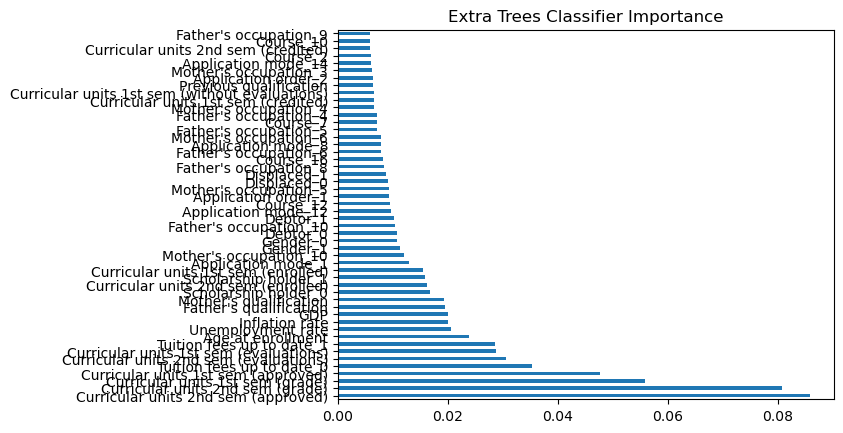

In [466]:
largest = select_features(one_hot, target, 50, 1)
categorical_labels_filter = list(set(categorical_labels).intersection(largest))
X_train, X_test, y_train, y_test = train_test_split(
  one_hot[largest], target, test_size=0.33)

In [410]:
nn.fit(X_train.values, y_train.values)
print(f"training score: {nn.score(X_train.values,y_train.values)}")
print(f"testing score: {nn.score(X_test.values,y_test.values)}")

training score: 0.7682186234817814
testing score: 0.7589041095890411


In [411]:
clf = SVC(kernel='linear')
clf.fit(X_train.values,y_train.values)
clf.score(X_test.values,y_test.values)

0.7780821917808219

#### Data Standardization

Each feature has a set of values on a range of scales. The issue with this is that some scales might be so large that the matrix math being done during training might skew the results towards certain features. In order to combat this, standardization is employed in which every feature is somehow shifted to a state that doesn't bias one or the other. The technique used below is StandardScaler which centers all the features at 0 and sets the standard deviation to 1.

In [428]:
scaler = preprocessing.StandardScaler()
scaled_one_hot = one_hot.copy()
scale_features = features.columns.difference(categorical_labels)
for feature in scale_features:
    df_scaled = scaler.fit_transform(one_hot[feature].to_numpy().reshape(-1,1))
    scaled_one_hot[feature] = df_scaled
    
scaled_one_hot

,Previous qualification,Mother's qualification,Father's qualification,Age at enrollment,International,Curricular units 1st sem (credited),Curricular units 1st sem (enrolled),Curricular units 1st sem (evaluations),Curricular units 1st sem (approved),Curricular units 1st sem (grade),...,Educational special needs_0,Educational special needs_1,Debtor_0,Debtor_1,Tuition fees up to date_0,Tuition fees up to date_1,Gender_0,Gender_1,Scholarship holder_0,Scholarship holder_1
0,-0.386404,0.075111,-0.584526,-0.430363,-0.159682,-0.300813,-2.528560,-1.986068,-1.521257,-2.197102,...,1,0,1,0,0,1,0,1,1,0
1,-0.386404,-1.254495,-1.218380,-0.562168,-0.159682,-0.300813,-0.109105,-0.550192,0.418050,0.693599,...,1,0,1,0,1,0,0,1,1,0
2,-0.386404,1.072315,0.954834,-0.562168,-0.159682,-0.300813,-0.109105,-1.986068,-1.521257,-2.197102,...,1,0,1,0,1,0,0,1,1,0
3,-0.386404,1.183116,0.954834,-0.430363,-0.159682,-0.300813,-0.109105,-0.071567,0.418050,0.575611,...,1,0,1,0,0,1,1,0,1,0
4,-0.386404,1.072315,1.045384,2.864765,-0.159682,-0.300813,-0.109105,0.167746,0.094832,0.349468,...,1,0,1,0,0,1,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4419,-0.386404,-1.254495,-1.399481,-0.562168,-0.159682,-0.300813,-0.109105,-0.310879,0.094832,0.611007,...,1,0,1,0,0,1,0,1,1,0
4420,-0.386404,-1.254495,-1.399481,-0.693973,6.262442,-0.300813,-0.109105,-0.550192,0.418050,0.280641,...,1,0,0,1,1,0,1,0,1,0
4421,-0.386404,1.072315,0.954834,0.887688,-0.159682,-0.300813,0.294137,-0.071567,0.741268,0.882010,...,1,0,1,0,0,1,1,0,0,1
4422,-0.386404,1.072315,0.954834,-0.430363,-0.159682,-0.300813,-0.512348,-0.789505,0.094832,0.652303,...,1,0,1,0,0,1,1,0,0,1


In [469]:
X_train, X_test, y_train, y_test = train_test_split(
  scaled_one_hot[largest], target, test_size=0.33)

nn = MLPClassifier(hidden_layer_sizes = (36,30,28),
                   activation = "relu", # Activation function for the hidden layer.
                   alpha = 0.001, # Strength of the L2 regularization term.
                   batch_size = 'auto',# Size of minibatches for stochastic optimizers.
                   learning_rate_init = 0.01, 
                   epsilon =1e-6,
                   max_iter = 1000,
                   shuffle = True,# shuffle samples in each iteration
                   early_stopping = True,
                   random_state=69,
                   verbose = False) # Allows to print progress messages to stdout.

nn.fit(X_train.values, y_train.values)
print(f"training score: {nn.score(X_train.values,y_train.values)}")
print(f"testing score: {nn.score(X_test.values,y_test.values)}")

training score: 0.8154520917678812
testing score: 0.7726027397260274


In [468]:
clf = SVC(kernel='linear')
clf.fit(X_train.values,y_train.values)
clf.score(X_test.values,y_test.values)

0.7787671232876713

Given these preprocessing changes, the performance of the neural network has risen by a good 3 percent than how it initially started. This is not largest difference, but it shows how tuning the general features that enter a neural network can improve its reliability.

With our results, we can identify to a good degree the students that might be at risk of dropping out of school from other information about them. Knowing the early warning signs can allow us to allocate resources or attention towards those in need.